<a href="https://colab.research.google.com/github/SatyaanikaPandam/Data-Science/blob/main/Saty_PandU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project explores how various biological factors influence petal width in iris flowers. The iriis dataset features varibles of sepal length, sepal width, petal length, and petal width across different iris species. These characteeristics are crucial for differentiating species and studying variations in flower structure. Petal width is shaped by a combination of genetic traits, environmental influences, and evolutionary adaptations. My goal is to identify  the key facctors that have the most significant impact on petal width.

In [3]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

In [26]:
#load the data into a pandas dataframe then you should print it
url_iris = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/iris.csv'
iris = pd.read_csv(url_iris)


In [7]:
print(iris)

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


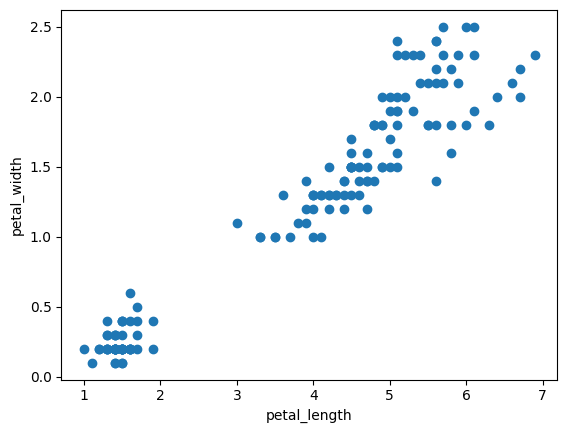

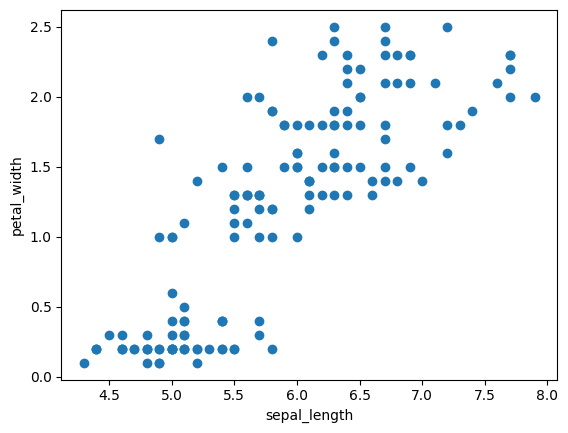

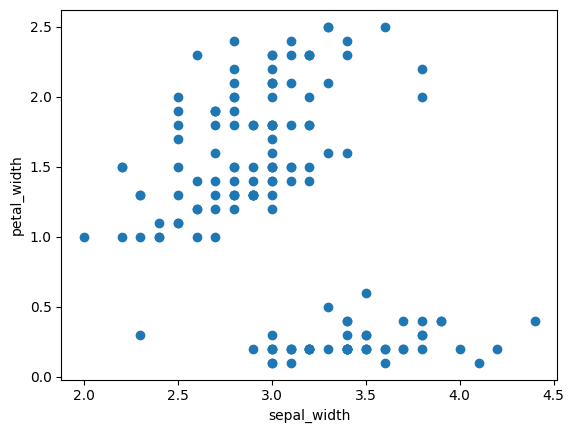

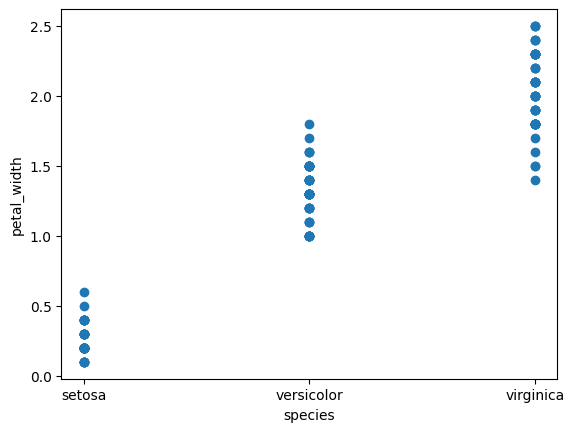

In [6]:
x = ["petal_length", "sepal_length", "sepal_width", "species"]
y = "petal_width"
for a in x:
  plt.scatter(iris[a], iris[y])
  plt.xlabel(a)
  plt.ylabel(y)
  plt.show()

These scatter plots show which variables in the dataset show clear direct or indirect relationships. Petal length and petal widht display a strong linear pattern, meaning there is a direct relationship between these two features. The clear line indicates that as petal length increases, petal width also increases. This means there is a potential “causal” relationship. On the other hand, sepal length and sepal width do not show the same level of clear correlation. The points are all over the place indicating a weaker or more weird/complex relationship between these two variables. This could mean that while sepal measurements might still be useful for classification, they do not provide as strong a direct connection as petal measurements. When we examine the scatter plot comparing species with sepal width, we see clear separations among species groups, which supports the idea that species classification is influenced by sepal width to some degree. However, petal length with petal width and petal width with sepal length are likely better predictors because of their strong linearity.


In [8]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.9 MB/s eta 0:00:00


In [9]:
import bambi as bmb

In [27]:
#negative binomial model
with pm.Model() as model_nbb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model
    μ = pm.Deterministic("μ", pm.math.exp(α + β * iris.petal_length))

    #prior ---> likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)
    #likelihood
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=iris.petal_width)

    idata_nbb = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

A negative binomial model utilizes a single predictor variable, i think we will use petal length  because it has the best strong relationship with petal width. The multiple linear model includes two predictor variables: petal length and sepal length.

In [11]:
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [28]:
#multiple linear
with pm.Model() as model_mlb:

    #priors on the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)

    #linear aspect
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * iris.petal_length + β1 * iris.sepal_length))

    #prior --> standard deviation
    σ = pm.HalfNormal("σ", 10)
    #likelihood
    y = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=iris.petal_width)
    idata_mlb = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [13]:
pm.sample_posterior_predictive(idata_mlb, model = model_mlb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
az.loo(idata_mlb)

,0
elpd_loo,-127.686901
se,6.636856
p_loo,0.478325
n_samples,2000
n_data_points,150
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [29]:
cmp_df = az.compare( {"multi_lin":idata_mlb,"single_lin":idata_nbb} )
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-127.705166,0.485879,0.000000,1.000000e+00,6.626951,0.000000,False,log
single_lin,1,-129.588048,0.388297,1.882883,6.661338e-16,6.177149,0.990742,False,log


This chart looks at the single and multiple models, and our goal is to select the one with the higher value. Although both values are negative, we choose the one that is less negative, as it indicates better predictive accuracy. /he warning is false for both models, which is a positive sign, as it confirms that the K diagnostic was good.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

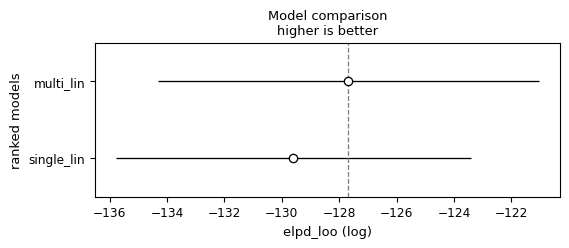

In [16]:
az.plot_compare(cmp_df)

Since models closer to this line are considered better, the multi_lin model outperforms the single_lin model. While both models have negative ELPD values, this visualization clearly highlights which model provides a better fit.

In [17]:

!pip install bambi

In [18]:
iris = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/iris.csv')

In [30]:
model_iris = bmb.Model("`petal_width` ~ `petal_length` + `sepal_length`", data=iris)
idata_iris= model_iris.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='petal_length', ylabel='petal_width'>], dtype=object))

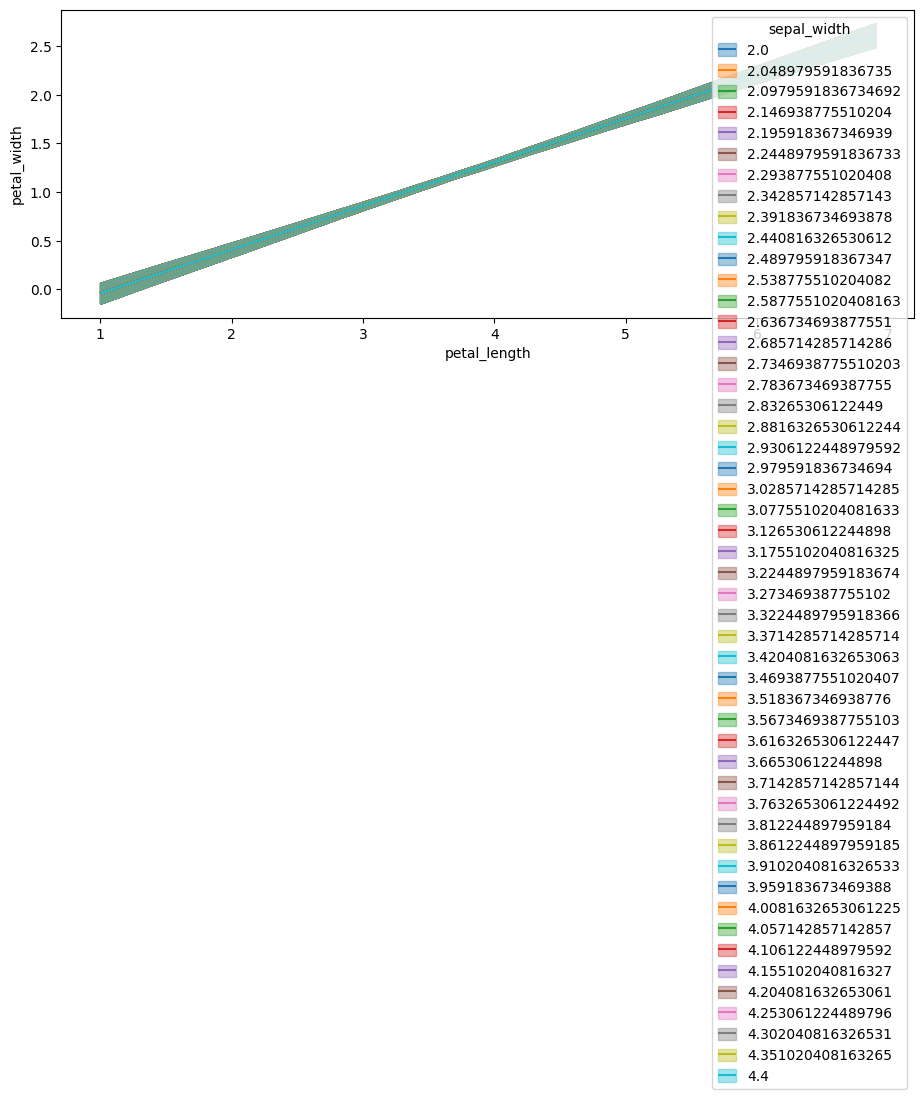

In [20]:
bmb.interpret.plot_predictions(model_iris,
                               idata_iris,
                                ["petal_length",  "sepal_width"], fig_kwargs={"figsize":(11, 4)})

The graph illustates a positive correlation between petal length and sepal length with petal width. As either variable increases, petal width also increases. The slope's steepnesss shows the degree of impact on petal width, with petal length likely having a steeper slope, suggesting a stronger infiuence on petal width compared to sepal length.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='sepal_length', ylabel='petal_width'>], dtype=object))

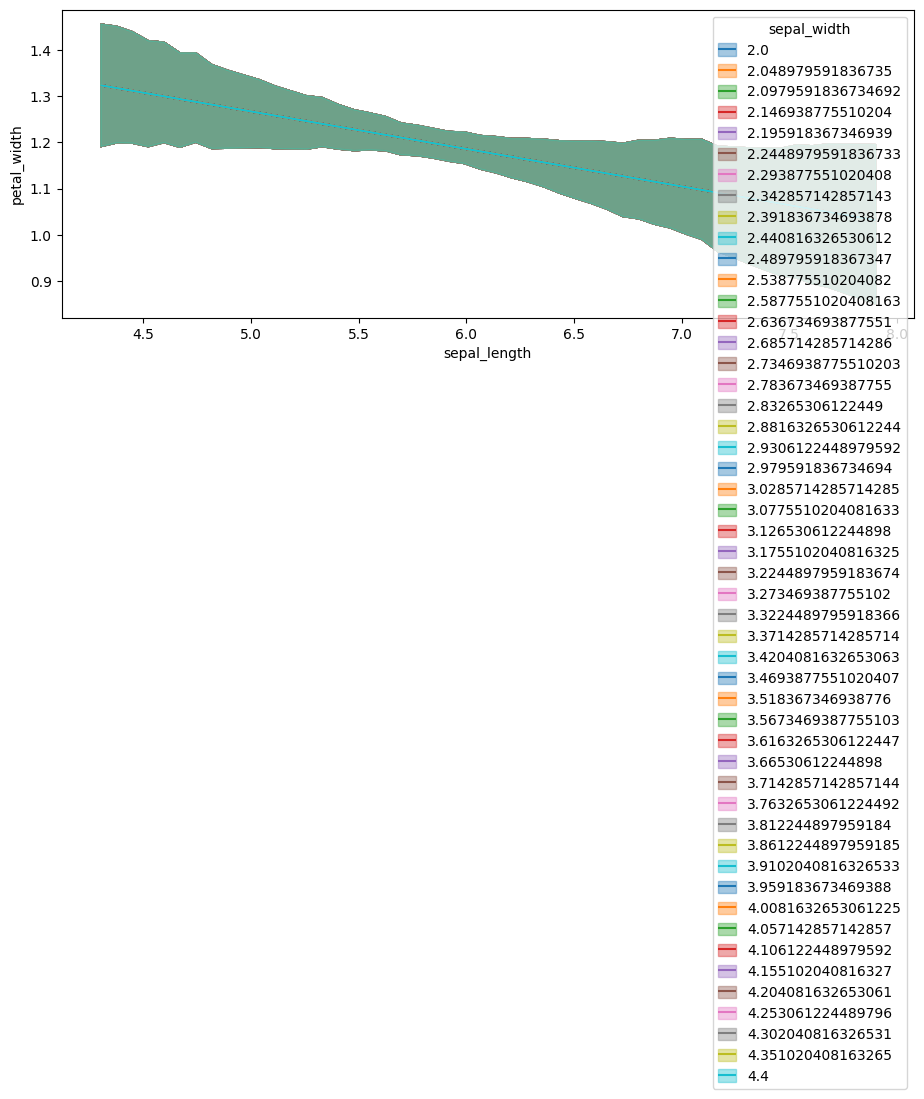

In [22]:
bmb.interpret.plot_predictions(model_iris,
                               idata_iris,
                                ["sepal_length",  "sepal_width"], fig_kwargs={"figsize":(11, 4)})

The graph illustates a negative correlation between sepal length and sepal width with petal width.So this is not a good graph.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='sepal_length', ylabel='petal_width'>], dtype=object))

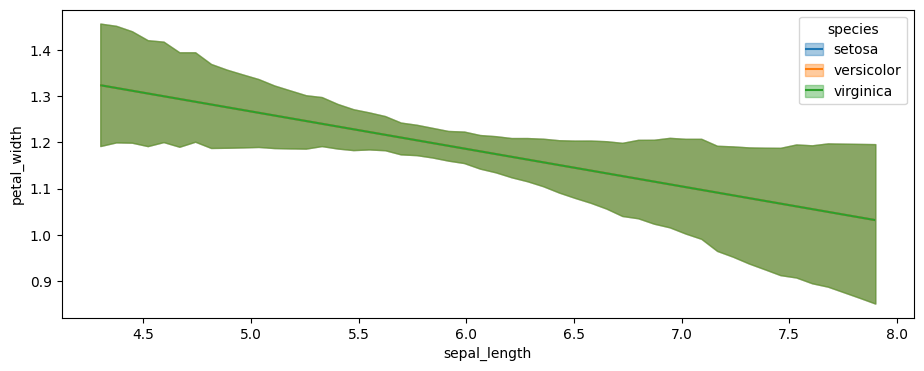

In [25]:
bmb.interpret.plot_predictions(model_iris,
                               idata_iris,
                                ["sepal_length",  "species"], fig_kwargs={"figsize":(11, 4)})

The graph illustates a negative correlation between sepal length and species with petal width. So this is also not a good graph.

In [31]:
model_ir_interq = bmb.Model("`petal_width` ~ `petal_length` + `sepal_length` + `petal_length` * `sepal_length`", data=iris)
#the model
idata_ir_interq = model_ir_interq.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


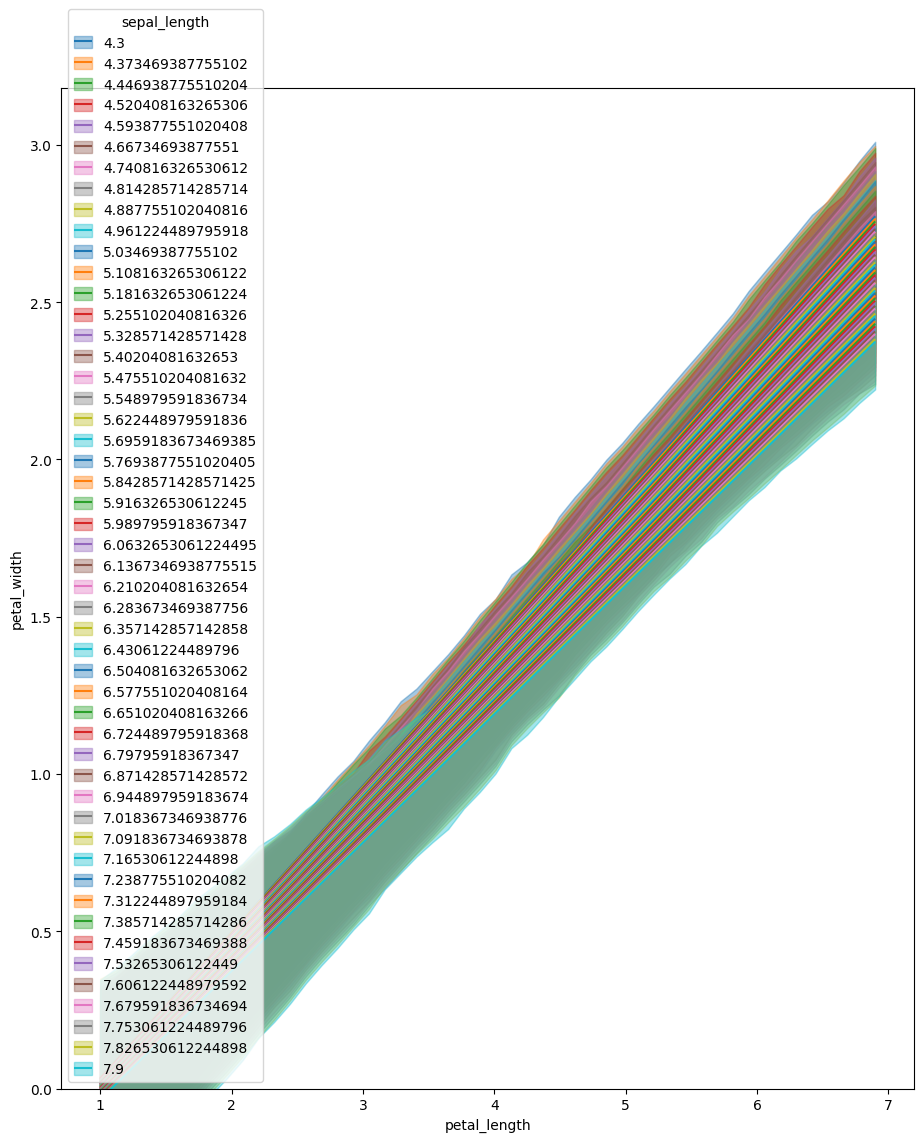

In [32]:
bmb.interpret.plot_predictions(model_ir_interq,
                               idata_ir_interq,
                               ["petal_length","sepal_length"],
                               fig_kwargs={"figsize":(11, 13)})#,

plt.ylim(0)  # Set the minimum limit --> 0

plt.show()

# Conclusion
This final graph provides a visual representation of how petal width changes bassed on both petal length and sepal length. I chose to create this graph because, during my research for the causal graph, I learned that sepal length and petal length directly influence petal width. This made me curiious to see if the relationship would hold true in this visualization/data. Looking at the graph, the lines are not completely parallel, which suggests that the effect of petal length on petal width is not allways the same, it changes depeinding on sepal length. The different slopes of the lines show how the impact of petal length varies when sepal length is different. This variation gives us more insight into how these factors interact to influence petal width.

Below I have all of the graphs that I tried to make before the graphs above. But I wanted to include them because they helped me take a differnet approach in the end. I didn't write any explinantions but this is just to show the weird looking graphs I created.

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [ ]:
# We put the priors that aren't normal or half normal with mean 0 and sigma 1
# in a dict
priors = {
    "petal_length": bmb.Prior("Normal", mu=0, sigma=10),
    "petal_width": bmb.Prior("Normal", mu=0, sigma=10),
    "sepal_length": bmb.Prior("Normal", mu=0, sigma=10),
    "sepal_width":bmb.Prior("Normal", mu=0, sigma=10),
    "species": bmb.Prior("Normal", mu=0, sigma=10),
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),  # Prior for the intercept
    "1|y_pred": bmb.Prior("HalfNormal", sigma=10)  # Prior for the likelihood's sigma
}

# This creates a skeleton of the model
model_nbb_bmb = bmb.Model(
    "petal_width ~ petal_length + sepal_width + sepal_length + species",
    iris,
    family="negativebinomial",
    priors=priors
)

In [ ]:
model_nbb_bmb

       Formula: petal_width ~ petal_length + sepal_width + sepal_length + species
        Family: negativebinomial
          Link: mu = log
  Observations: 150
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            petal_length ~ Normal(mu: 0.0, sigma: 10.0)
            sepal_width ~ Normal(mu: 0.0, sigma: 10.0)
            sepal_length ~ Normal(mu: 0.0, sigma: 10.0)
            species ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)

In [ ]:
#this is bambi's equivalent of pm.sample()
idata_nbb_bmb = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


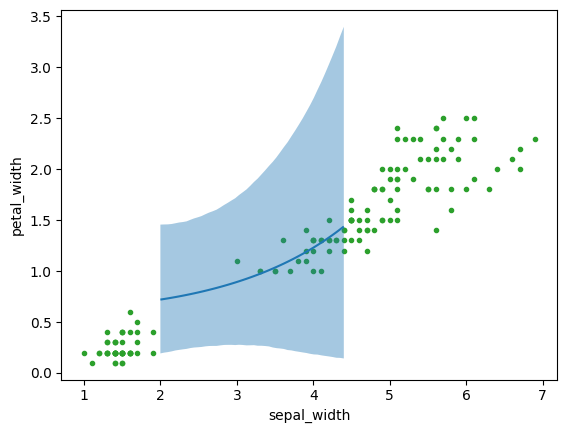

In [ ]:
bmb.interpret.plot_predictions(
    model_nbb_bmb,
    idata_nbb_bmb,
    conditional=["sepal_length", "sepal_width", "species"],
    average_by="sepal_width"  # Specify a covariate to average by
)
plt.plot(iris.petal_length, iris.petal_width, "C2.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='sepal_width', ylabel='petal_width'>], dtype=object))

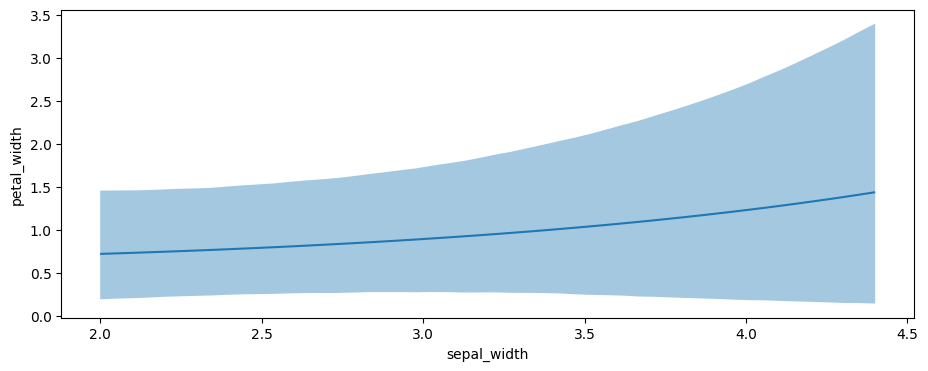

In [ ]:
bmb.interpret.plot_predictions(
    model_nbb_bmb,
    idata_nbb_bmb,
    conditional=["sepal_length", "sepal_width", "species"],  # Pass column names as strings
    average_by="sepal_width",  # Specify one of the covariates to average by
    fig_kwargs={"figsize": (11, 4)}
)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


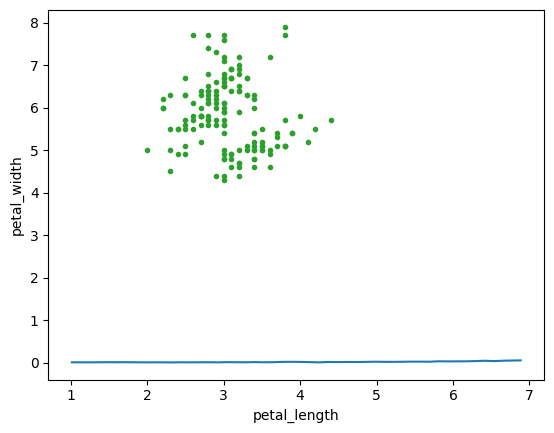

In [ ]:
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb,"petal_length", pps=True)
plt.plot(iris.sepal_width, iris.sepal_length, "C2.", zorder=-3)

<Axes: xlabel='petal_width'>

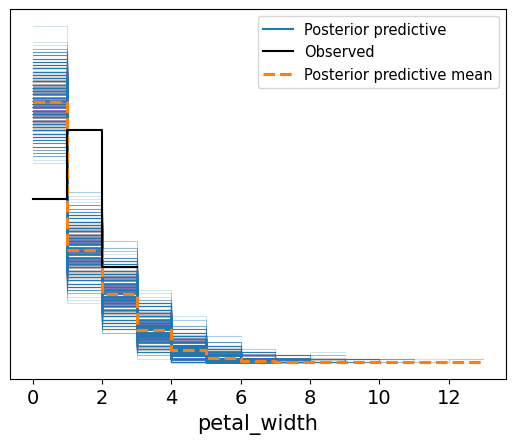

In [ ]:
model_nbb_bmb.predict(idata_nbb_bmb, kind="response")
az.plot_ppc(idata_nbb_bmb)

In [ ]:
# Notice that the priors argument isn't specified
model_nbb_bmb_regpriors = bmb.Model("petal_width ~ petal_length + sepal_width + sepal_length + species", data=iris, family="negativebinomial")  # Added 'data='
idata_nbb_bmb_regpriors = model_nbb_bmb_regpriors.fit(idata_kwargs={"log_likelihood": True})

Output()

Output()

In [ ]:
model_nbb_bmb_regpriors

       Formula: petal_width ~ petal_length + sepal_width + sepal_length + species
        Family: negativebinomial
          Link: mu = log
  Observations: 150
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 25.7662)
            petal_length ~ Normal(mu: 0.0, sigma: 1.4209)
            sepal_width ~ Normal(mu: 0.0, sigma: 5.7549)
            sepal_length ~ Normal(mu: 0.0, sigma: 3.0292)
            species ~ Normal(mu: [0. 0.], sigma: [5.3033 5.3033])
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


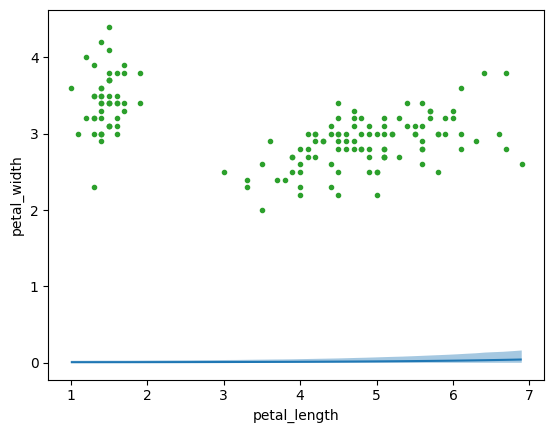

In [ ]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "petal_length")
plt.plot(iris.petal_length, iris.sepal_width, "C2.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


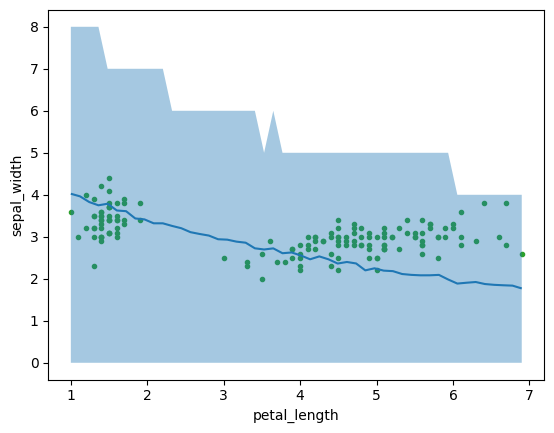

In [ ]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "petal_length", pps=True)
plt.plot(iris.petal_length, iris.sepal_width, "C2.", zorder=-3)

In [ ]:
model_mlb_bmb = bmb.Model("sepal_width ~ petal_length + petal_width", iris, family="negativebinomial")
idata_mlb_bmb = model_mlb_bmb.fit(idata_kwargs={"log_likelihood": True})

Output()

Output()

In [ ]:
model_mlb_bmb

       Formula: sepal_width ~ petal_length + petal_width
        Family: negativebinomial
          Link: mu = log
  Observations: 150
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.0952)
            petal_length ~ Normal(mu: 0.0, sigma: 1.4209)
            petal_width ~ Normal(mu: 0.0, sigma: 3.2908)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


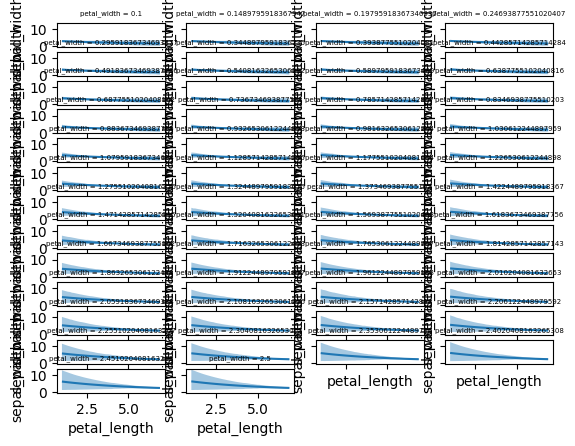

In [ ]:
bmb.interpret.plot_predictions(
    model_mlb_bmb,
    idata_mlb_bmb,
    ["petal_length", "petal_width",],
    subplot_kwargs={"group": None, "panel": "petal_width"},
    legend=False,
    fig_kwargs={"sharey": True, "sharex": True}
)

# Get the current axes (subplots)
axes = plt.gcf().get_axes()

# Iterate through the axes and adjust the title size
for ax in axes:
    ax.set_title(ax.get_title(), fontsize=5)  # Set fontsize to 10 (adjust as needed)

plt.show()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 52 Axes>,
 array([[<Axes: title={'center': 'petal_width = 0.1'}, xlabel='petal_length', ylabel='sepal_width'>,
         <Axes: title={'center': 'petal_width = 0.1489795918367347'}, xlabel='petal_length', ylabel='sepal_width'>,
         <Axes: title={'center': 'petal_width = 0.19795918367346937'}, xlabel='petal_length', ylabel='sepal_width'>,
         <Axes: title={'center': 'petal_width = 0.24693877551020407'}, xlabel='petal_length', ylabel='sepal_width'>],
        [<Axes: title={'center': 'petal_width = 0.29591836734693877'}, xlabel='petal_length', ylabel='sepal_width'>,
         <Axes: title={'center': 'petal_width = 0.3448979591836735'}, xlabel='petal_length', ylabel='sepal_width'>,
         <Axes: title={'center': 'petal_width = 0.3938775510204081'}, xlabel='petal_length', ylabel='sepal_width'>,
         <Axes: title={'center': 'petal_width = 0.44285714285714284'}, xlabel='petal_length', ylabel='sepal_width'>],
        [<Axes: title={'center': 'petal_widt

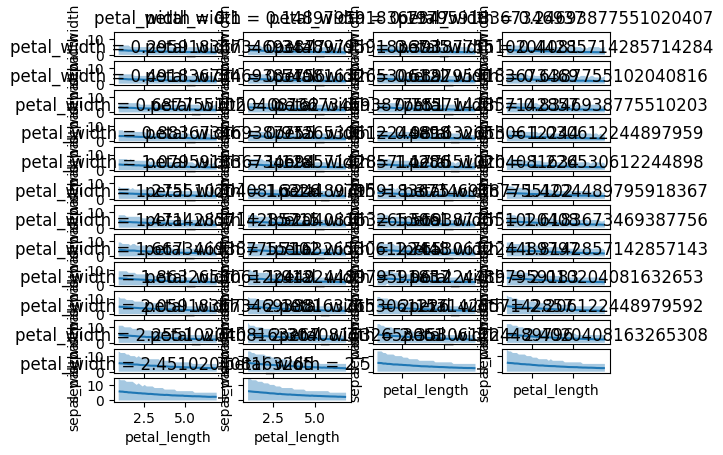

In [ ]:
bmb.interpret.plot_predictions(
    model_mlb_bmb,
    idata_mlb_bmb,
    ["petal_length", "petal_width"],
    subplot_kwargs={"group": None, "panel": "petal_width"},
    legend=False,
    fig_kwargs={"sharey": True, "sharex": True},
    pps=True  # Include posterior predictive samples
)